**Note**: The following notebook implements Part 1 of the project. Due to python incompatibility issues faced in the implementation of the Qfp fingerprinting algorithm, the `MIR_final_project_Part2.ipynb` is loaded in python2 runtime.



#Evaluating Robustness of Audio Fingerprinting Methods
The following notebook is presented by Aditya Bhattacharjee as part of the final project of Music Information Retrieval. The notebook is divided into two parts:


*   Part 1: Loading the Dataset
*   Part 2: Evaluating Chromaprint


This python notebook aims to be self-explanatory and should be run in a Google Colaboratory environment. The second algorithm is evaluated in MIR_final_project_Part2.pynb . The reason for this is that the implementation of Qfp algorithm is compatible only with python *2.7*





## Loading the Dataset

The dataset used in this project is the GTZAN Genre Classification dataset. The dataset contains 1000 audio pieces, each of which are 30 seconds long. Further details about the dataset has been discussed in the report for this project. 

In [ ]:
!pip install ffmpeg
!pip install essentia
!pip install mirdata 
!pip install pyacoustid
!pip install pydub
!pip install difflib
!pip install audio-degrader
!pip install sox
!sudo apt-get install sox libsox-fmt-all

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6083 sha256=ff1d480a9e89fcfad82306d6e0a08299b2566280cdcf3d55786dd2807a5c723f
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg
     |████████████████████████████████| 12.0MB 293kB/s 
     |████████████████████████████████| 7.1MB 6.1MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 5.6MB 15.4MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 92kB 874kB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for jams: filename=jams-0.3.4-cp37-none-any.whl size=64926 sha256=e9ccf91a2fd195ce2032994ea995fd3519a26e5325fd38ebb3203a6a0f42183c
  Stored in directory: /root/.cache/pip/wheels/2b/b8/c7/092096a3af0eb864cca4e79a44bc883dee5b9767da2c6f8ab3
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size

In [ ]:
import ffmpeg
import os 
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from mirdata import initialize
from mirdata.datasets import gtzan_genre
from mirdata.datasets.gtzan_genre import Dataset
from essentia.standard import MonoLoader,Chromaprinter
import acoustid as ai
from pydub import AudioSegment
from difflib import SequenceMatcher
import audio_degrader as ad
import sox
import pandas as pd

The following chunk of code mounts the google drive for ease-of-access and prevention of data loss due to session timeouts. The implementation required certain audio files to simulate the noisy environment for testing. Please download the required zip file from [this](https://drive.google.com/file/d/1k2lMSGDa4TfwOqu44ZCaKflGCWkyuy40/view?usp=sharing) link and upload it in this block of code. (Please contact the author in case the zip file is corrupted)

In [ ]:
# Mounting google drive and loading required noise samples from url

from google.colab import drive,files
drive.mount('/gdrive',force_remount=True)
print("Please upload zip file from the link provided above")
files.upload()
!unzip /content/Noise_sounds.zip

Mounted at /gdrive
Please upload zip file from the link provided above


Saving Noise_sounds.zip to Noise_sounds (1).zip
Archive:  /content/Noise_sounds.zip
replace Noise sounds/ambience-pub.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Noise sounds/ir_hall.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


The dataset is loaded into the mounted Google drive using the `mirdata` python library.

In [ ]:
gtzan = initialize('gtzan_genre', data_home='/gdrive/MyDrive')
gtzan.download() 
gtzan.validate(verbose=True)

INFO: Downloading ['all'] to /gdrive/MyDrive
INFO: [all] downloading genres.tar.gz
1.14GB [12:19, 1.66MB/s]                            
100%|██████████| 1000/1000 [00:07<00:00, 139.39it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'tracks': {}}, {'tracks': {}})

In [ ]:
# Organizing the tracks subdirectory to extract files from the subfolder

folder = r"/gdrive/MyDrive/gtzan_genre/genres"
subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]

for sub in subfolders:
    for f in os.listdir(sub):
        src = os.path.join(sub, f)
        dst = os.path.join(folder, f)
        shutil.move(src, dst)
    shutil.rmtree(sub)
    
test = os.listdir(folder)
for item in test:
    if item.endswith(".mf"):
        os.remove(os.path.join(folder, item))

## Evaluating Chromaprint
Chromaprint is an audio fingerprinting algorithm which computes a compact representation of the chroma features to derive the fingerprint. For this, it uses a set of pre-defined bnary filter and concolved it on the chromagram image.

The following section:


*   Creates a fingerprint database from the GTZAN dataset
*   Observes the effect of noise query audio on performance
*   Observes the effect of time-shift and pitch shift on the performance




In [ ]:
# In case of a session timeout, re-run the notebook starting from this cell

path = '/gdrive/MyDrive/gtzan_genre/genres'

In [ ]:
# Utility functions

def build_fingerprint_database(dirpath):
    """
    Build database from directory of audio files
    """
    database = {}
    loader = MonoLoader()
    print('Processing {}..'.format(dirpath))
    for filename in os.listdir(dirpath):
      loader.configure(filename=os.path.join(dirpath,filename), sampleRate=44100)
      audio = loader()
      fp = Chromaprinter()(audio)
      fp_byte = bytes(fp, 'utf-8')
      fp_int = ai.chromaprint.decode_fingerprint(fp_byte)[0]
      database[filename] = fp_int
    print("Process completed")
    if not os.path.exists(os.path.join("\content\chromaprint_db.pkl")):
      f = open("chromaprint_db.pkl", "wb")
      pickle.dump(database, f)
      f.close()
    return database 

def sample_audio_chunks(no_of_files,chunk_size):
    """
    Create a directory containing randomly sampled chunks of audio files
    """
    dirpath = dirpath = os.path.join(path, 'Sampled_chunk_('+ str(chunk_size) + 'seconds)')
    if not os.path.exists(dirpath):
      files = os.listdir(path)
      os.mkdir(dirpath)
      for file_name in random.sample(files, no_of_files):
        shutil.copy(os.path.join(path, file_name), dirpath)
      filenames = next(os.walk(dirpath))[2] 
      for f in filenames:
        fpath = os.path.join(dirpath,f)
        song = AudioSegment.from_wav(fpath)
        offset = random.randrange(0,len(song)-chunk_size*1000)
        chunk = song[offset : offset + chunk_size*1000]
        os.remove(fpath)
        chunk.export(dirpath+"/"+f, format="wav")
    return dirpath

def calculate_hit_rate(N,database,samples):
    """
    Calculate the top_N_hit_rate for the query matching task
    """
    hit = {}
    hit_count = np.zeros(N)
    for sample, sample_fp in samples.items():
        # print('Computing top match for "{}"'.format(sample))
        top_match = {}
        for name, fp in database.items():
            similarity = SequenceMatcher(None, sample_fp, fp).ratio()
            top_match[name] = similarity
        top = sorted(top_match, key=top_match.get, reverse=True)[:N]
        hit[sample] = top
    for name, res in hit.items():
        for ix in range(N):
            if name == res[ix]:
                hit_count[ix] += 1

    return np.cumsum(hit_count)/len(samples)

def degrade_audio_chunk(dirpath):
    """
    Degrade the query audio chunks for evaluating robustness
    """
    for filename in os.listdir(dirpath):
        audio_file = ad.AudioFile(os.path.join(dirpath,filename), dirpath)
        os.remove(os.path.join(dirpath,filename))
        degradations = ad.ParametersParser.parse_degradations_args(['convolution,/content/Noise sounds/ir_hall.wav,0.5','mix,/content/Noise sounds/ambience-pub.wav,10'])
        for d in degradations:
            audio_file.apply_degradation(d);
        audio_file.to_wav(dirpath + '/' + filename)
        audio_file.delete_tmp_files()
    return dirpath

def pitch_shift_chunk(dirpath,factor):
    """
    Pitch-shift the query audio chunks for evaluating robustness
    """
    for filename in os.listdir(dirpath):
        audio_file = ad.AudioFile(os.path.join(dirpath,filename), dirpath);
        os.remove(os.path.join(dirpath,filename))
        degradations = ad.ParametersParser.parse_degradations_args(['pitch_shift,'+str(factor)]);
        for d in degradations:
            audio_file.apply_degradation(d);
        audio_file.to_wav(dirpath + '/' + filename)
        audio_file.delete_tmp_files()
    return dirpath

def time_stretch_chunk(dirpath,factor):
    """
    Time-stretch the query audio chunks for evaluating robustness
    """
    for filename in os.listdir(dirpath):
        audio_file = ad.AudioFile(os.path.join(dirpath,filename), dirpath);
        os.remove(os.path.join(dirpath,filename))
        degradations = ad.ParametersParser.parse_degradations_args(['time_stretch,'+str(factor)]);
        for d in degradations:
            audio_file.apply_degradation(d);
        audio_file.to_wav(dirpath + '/' + filename)
        audio_file.delete_tmp_files()
    return dirpath

Now, we compute the reference database using the `build_fingerprint_database` utility function. For ease-of-access the `database` is stored in the locak runtime disk space. From the GTZAN dataset, we sample 200 audio pieces and truncate it into 2.5, 5, 10, and 20 second snippets (with random offsets) each; this forms our test set. For each of these 200 (times the 4 types of snippets), we calculate the **top-3 hit rate**, i.e., the number of times the query was matched correctly in the top 3 highest scored searched results. For the sake of brevity, the sample size in this reduced to 100 audio snippets. The results in the report, however, are the mean average hit rates computed over 200 sample size for 5 samples.

It must be noted here that the query search in this example is not optimized. The source code performs the query search and match using an API call to a PostGRE SQL code written in C. This is not suited for our task, since we are testing the framework on a tailor-made database. For the sake of this project, an exhaustive search is performed and similarity is composed using Levenshtein distance between the candidate and query pair.

The function `build_fingerprint_database` takes about 10 minutes to execute. In case of inconvenience, download the pickled database from [here](https://drive.google.com/file/d/1D9ywN20et-sgi0iGv_OjxlG0VaQhB08o/view?usp=sharing) and upload it to the notebook. The `plk` file has to be converted into a dictionary and stored in `database` for the sake of consistency. The required code has been commented out below

In [ ]:
database = build_fingerprint_database(path)

''' For uploading and loading the pkl file, comment to code above uncomment the code below'''

# files.upload()
# file_to_read = open("/content/database.pkl", "rb")
# database = pickle.load(file_to_read)


Saving database (1).pkl to database (1).pkl


In [ ]:
# Computing Top-3 hit rate

CHUNK = [2.5,5,10,20]
top_N_hit_rate = []
for i in range(4):
  dirpath = sample_audio_chunks(no_of_files = 100,chunk_size = CHUNK[i])
  samples = build_fingerprint_database(dirpath)
  hit_rate = calculate_hit_rate(N = 3, database=database, samples=samples)
  top_N_hit_rate.append(hit_rate)
  shutil.rmtree(dirpath)

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(2.5seconds)..
Process completed
Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(5seconds)..
Process completed
Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed
Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(20seconds)..
Process completed


The plot given below is an example of the binary representation of the fingerprint computed for a single audio piece. In practice, the fingerprint is further compressed into a string representation. 

Text(0.5, 1.0, 'Binary representation of a Chromaprint ')

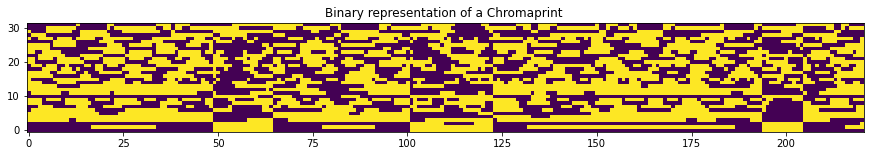

In [ ]:
fp_int = list(database.values())[0]
fb_bin = [list('{:032b}'.format(abs(x))) for x  in fp_int] # Int to unsigned 32-bit array

arr = np.zeros([len(fb_bin), len(fb_bin[0])])

for i in range(arr.shape[0]):
    arr[i,0] = int(fp_int[i] > 0) # The sign is added to the first bit
    for j in range(1, arr.shape[1]):
        arr[i,j] = float(fb_bin[i][j])
plt.figure(figsize=(15,2))
plt.imshow(arr.T, aspect='auto', origin='lower')
plt.title('Binary representation of a Chromaprint ')

### Robustness to superimposed noise
We compute a query sample set which has been transformed in the following ways:


*   **Superposition of noise**: `ambient-pub.wav` is superimposed with the query audio to give create a noisy environment
*   **Convolution of IR filter** : convolution with `ir_hall.wav` simulates the reverberation in an empty octagonal auditorium.

The `audio degrader`[library](https://github.com/emilio-molina/audio_degrader/tree/37d57ffb4993ec51d7916e713cc3a468aeb0236d) uses SoX to provide an interface for a number of audio degradations. One issue in its implementation is that it does not provide a `verbose` flag. Hence, the `INFO` outputs cannot be suppressed. This results in obfuscating important information in the print output while executing it in a pipeline.

The fingerprints of the sample are matched with the reference database to compute the top-3 hit rate. To study the effect of the noise, the hit rate for the two cases are plotted.



In [ ]:
CHUNK = [2.5,5,10,20]
top_N_hit_rate_deg = []
for i in range(4):
  dirpath = sample_audio_chunks(no_of_files = 100,chunk_size = CHUNK[i])
  dirpath = degrade_audio_chunk(dirpath)
  samples = build_fingerprint_database(dirpath);
  hit_rate = calculate_hit_rate(N = 3, database=database, samples=samples)
  top_N_hit_rate_deg.append(hit_rate)
  shutil.rmtree(dirpath)

INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /co

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(2.5seconds)..
Process completed


INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /co

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(5seconds)..
Process completed


INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /co

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /content/Noise sounds/ir_hall.wav and level 0.500000
INFO: Convolving with /co

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(20seconds)..
Process completed


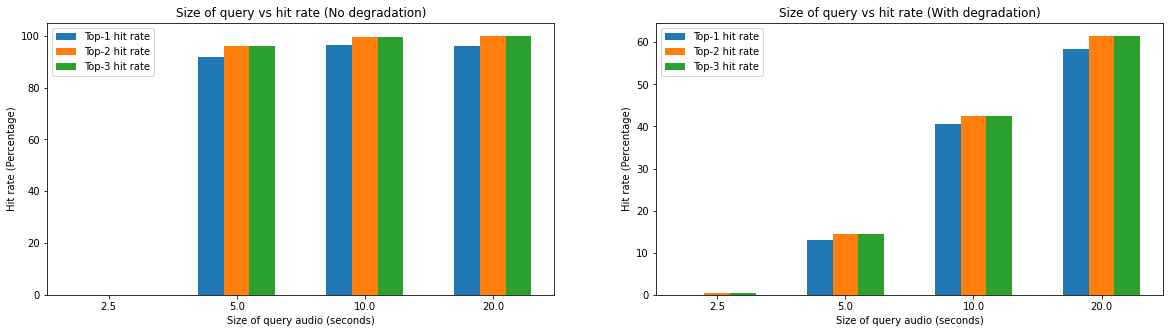

In [ ]:
y1 = np.array(top_N_hit_rate)
length = [2.5,5.0,10.0,20.0]
_X = np.arange(4)
plt.figure(figsize=[20,5])

y1 = np.array(top_N_hit_rate)
plt.subplot(1, 2, 1).set_title("Size of query vs hit rate (No degradation)")
plt.bar(_X - 0.2, y1[:,0]*100, 0.2,label="Top-1 hit rate")
plt.bar(_X, y1[:,1]*100, 0.2,label="Top-2 hit rate")
plt.bar(_X + 0.2, y1[:,2]*100, 0.2,label="Top-3 hit rate")
plt.xticks(_X, length)
plt.xlabel("Size of query audio (seconds)")
plt.ylabel("Hit rate (Percentage)")
plt.legend()

y2 = np.array(top_N_hit_rate_deg)
plt.subplot(1, 2, 2).set_title("Size of query vs hit rate (With degradation)")
plt.bar(_X - 0.2, y2[:,0]*100, 0.2,label="Top-1 hit rate")
plt.bar(_X, y2[:,1]*100, 0.2,label="Top-2 hit rate")
plt.bar(_X + 0.2, y2[:,2]*100, 0.2,label="Top-3 hit rate")
plt.xticks(_X, length)
plt.xlabel("Size of query audio (seconds)")
plt.ylabel("Hit rate (Percentage)")
plt.legend()

plt.show()


### Robustnes to pitch-shift and time-stretch

Pitch-shift and time-stretch is computed using the `audio_degrader` library. The effect of pitch-shift is tested for query samples computed with different pitch-shift factors. The chunk size of the query audio is 10 seconds. The hit rate observed are plotted.

In [ ]:
# Calculating the hit-rate on pitch-shifted query audio

FACTOR = [0.5,0.75,1,1.25,1.5]  # Pitch shift factor (multiplicative)
top_N_hit_rate_shift = []
for i in range(5):
  dirpath = sample_audio_chunks(no_of_files = 100,chunk_size = 10)
  dirpath = pitch_shift_chunk(dirpath,FACTOR[i])
  samples = build_fingerprint_database(dirpath)
  hit_rate = calculate_hit_rate(N = 3, database=database, samples=samples)
  top_N_hit_rate_shift.append(hit_rate)
  shutil.rmtree(dirpath)

INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. -4.980450 semitones
INFO: Shifting pitch with factor 0.750000, i.e. 

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semitones
INFO: Shifting pitch with factor 1.000000, i.e. 0.000000 semit

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semitones
INFO: Shifting pitch with factor 1.250000, i.e. 3.863137 semit

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semitones
INFO: Shifting pitch with factor 1.500000, i.e. 7.019550 semit

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


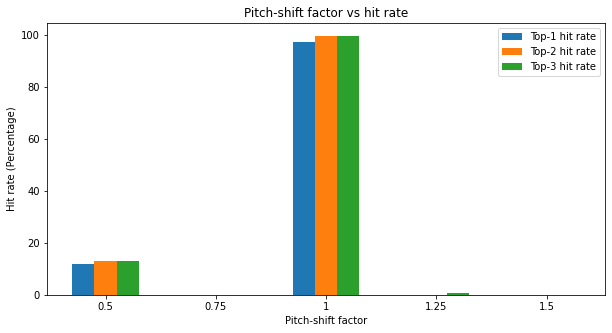

In [ ]:
y = np.array(top_N_hit_rate_shift)
FACTOR = [0.5,0.75,1,1.25,1.5]
_X = np.arange(5)
plt.figure(figsize=[10,5])

plt.title("Pitch-shift factor vs hit rate")
plt.bar(_X - 0.2, y[:,0]*100, 0.2,label="Top-1 hit rate")
plt.bar(_X, y[:,1]*100, 0.2,label="Top-2 hit rate")
plt.bar(_X + 0.2, y[:,2]*100, 0.2,label="Top-3 hit rate")
plt.xticks(_X, FACTOR)
plt.xlabel("Pitch-shift factor")
plt.ylabel("Hit rate (Percentage)")
plt.legend()
plt.show()

In [ ]:
FACTOR = [0.5,0.75,1,1.25,1.5]  # Time stretch factor (multiplicative)
top_N_hit_rate_stretch = []
for i in range(5):
  dirpath = sample_audio_chunks(no_of_files = 100,chunk_size = 10)
  dirpath = time_stretch_chunk(dirpath,FACTOR[i]);
  samples = build_fingerprint_database(dirpath)
  hit_rate = calculate_hit_rate(N = 3, database=database, samples=samples)
  top_N_hit_rate_stretch.append(hit_rate)
  shutil.rmtree(dirpath)

INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time stretching with factor 0.500000
INFO: Time 

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time stretching with factor 0.750000
INFO: Time 

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time stretching with factor 1.000000
INFO: Time 

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time stretching with factor 1.250000
INFO: Time 

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time stretching with factor 1.500000
INFO: Time 

Processing /gdrive/MyDrive/gtzan_genre/genres/Sampled_chunk_(10seconds)..
Process completed


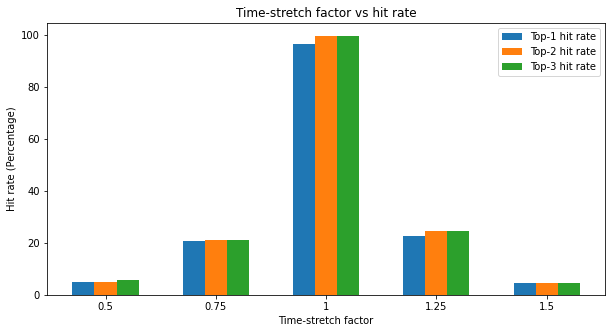

In [ ]:
y = np.array(top_N_hit_rate_stretch)
FACTOR = [0.5,0.75,1,1.25,1.5]
_X = np.arange(5)
plt.figure(figsize=[10,5])

plt.title("Time-stretch factor vs hit rate")
plt.bar(_X - 0.2, y[:,0]*100, 0.2,label="Top-1 hit rate")
plt.bar(_X, y[:,1]*100, 0.2,label="Top-2 hit rate")
plt.bar(_X + 0.2, y[:,2]*100, 0.2,label="Top-3 hit rate")
plt.xticks(_X, FACTOR)
plt.xlabel("Time-stretch factor")
plt.ylabel("Hit rate (Percentage)")
plt.legend()
plt.show()

# Prep for the next notebook

The second framework to be evaluated in this project is not compatible with python3. Hence, it is evaluated in a separate notebook (to be run in python2). The audio degrader is not python2 compatible, so we are creating the degraded audio then uploading into the drive.

The second notebook will download the degraded audio sample directory and evaluate the fingerprints on it. 

In [ ]:
files = os.listdir(path)
if not os.path.exists('/content/datafolder'):
  os.mkdir('/content/datafolder')

for i in range(5):
  dir_path = '/content/datafolder/sampled_audio_pitch_shift_'+str(FACTOR[i])
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  for file_name in random.sample(files, 100):
    shutil.copy(os.path.join(path, file_name), dir_path)
  dir_path = pitch_shift_chunk(dir_path,FACTOR[i])

for i in range(5):
  dir_path = '/content/datafolder/sampled_audio_time_stretch_'+str(FACTOR[i])
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  for file_name in random.sample(files, 100):
    shutil.copy(os.path.join(path, file_name), dir_path)
  dir_path = time_stretch_chunk(dir_path,FACTOR[i])


dir_path = '/content/datafolder/sampled_audio_degraded_'
if not os.path.exists(dir_path):
  os.mkdir(dir_path)
for file_name in random.sample(files, 100):
  shutil.copy(os.path.join(path, file_name), dir_path)
dir_path = degrade_audio_chunk(dir_path)

INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0.500000, i.e. -12.000000 semitones
INFO: Shifting pitch with factor 0

In [ ]:
from distutils.dir_util import copy_tree
copy_tree('/content/datafolder','/gdrive/MyDrive/gtzan_genre')

['/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/metal.00006.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/blues.00024.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/country.00048.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/country.00097.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/reggae.00028.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/reggae.00087.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/reggae.00047.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/rock.00057.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/blues.00044.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/disco.00096.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/metal.00003.wav',
 '/gdrive/MyDrive/gtzan_genre/sampled_audio_time_stretch_1.25/blues.00039.wav',
 '/gdrive/MyDrive/gtzan_genre/samp